# Experiência 3: Ruído de quantização em filtros IIR

Jean Carlos Mello Xavier Faria - 11259628

Oliver de Noronha Rissato - 11375361

Primeiramente vamos importar as bibliotecas necessárias

In [8]:
using PyPlot, SampledSignals, DSP, Statistics, FixedPointNumbers, PyCall, Polynomials, Conda

Vamos criar o sinal de áudio $ s(t) = 0,5 cos(2\pi f_{0}t) + 0,3 cos(4\pi 300t) + 0,15 cos(6\pi f_0 t)$. Sendo amostrado com uma frequência de $40kHz$ e com uma duração de $3s$.

In [9]:
fa = 40000
f0 = 100π
t = 0:1/fa:3

A1 = 0.5
A2 = 0.3
A3 = 0.15

B0 = 5

s = A1*cos.(2π*f0*t)+A2*cos.(4π*300t)+A3*cos.(6π*f0*t);

Agora vamos quantizar o sinal com 5 bits e depois vamos escutá-lo.

In [10]:
sq = Fixed{Int16, B0-1}.(s)
yq = SampleBuf(sq,fa)

120001-frame, 1-channel SampleBuf{Q11f4, 1}
3.000025s sampled at 40000.0Hz
▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇

Plotando o sinal discreto e o sinal quantizado, na mesma figura.

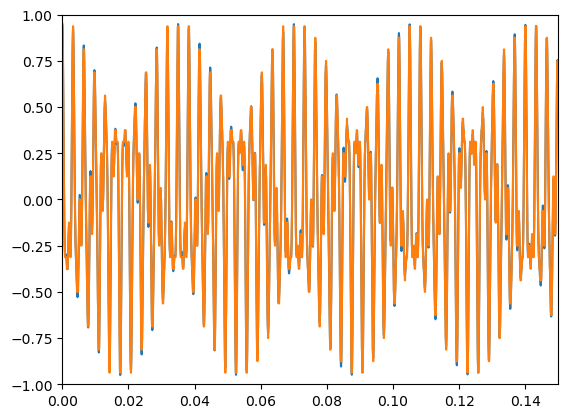

(0.0, 0.15, -1.0, 1.0)

In [11]:
plot(t, s)
plot(t, sq)
axis([0,0.15,-1,1])

Como podemos verificar, o sinal quantizado tem um erro com o sinal $s(t)$. Podemos observar essa diferença realizando a subtração entre ambos e plotando.

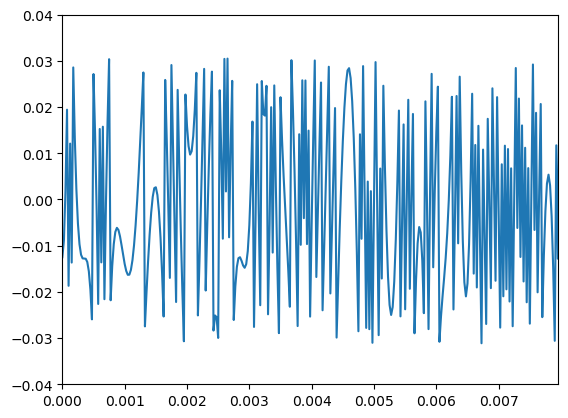

(0.0, 0.007957747154594767, -0.04, 0.04)

In [12]:
plot(t, sq-s)
axis([0,1/(40*pi),-0.04,0.04])

Vamos calcular a relação sinal/ruído (SNR) em dB. Para calculá-lo, vamos calcular a potência do sinal, dada por: $Pot. de s(t) = \frac{0,5^2+0,3^2+0,15^2}{2}$ e a potência do ruído $\sigma=\frac{2^{-2B0}}{3}$, com isso, $SNR=\frac{Pot. de s(t)}{\sigma}$.

In [19]:
PotSinal = A1^2/2 + A2^2/2 + A3^2/2
σ20 = (2.0^(-2*B0))/3
SNR = pow2db(PotSinal/(σ20));
println("SNR = ",SNR, " dB")

SNR = 27.456992266025058 dB


## Implementação do filtro IIR

Para a implementação do filtro IIR, foram utilizados os seguintes parâmetros.

In [14]:
#Filtro IIR
δp = 0.05
ωp = 2π*3*f0/fa
ωr = 0.2*ωp
ωc = (ωp+ωr)/2

Ap = -20*log10(1-δp)
Ar = 40

δr = 10^(-Ar/20);

Utilizaremos a aproximação elíptica, para isso, será usado a biblioteca de Python.

In [21]:
using Pkg
ENV["PYTHON"]=""
Pkg.build("PyCall")

sig = pyimport("scipy.signal")
N, Wn = sig.ellipord(ωp/π, ωr/π, Ap, Ar);
println("N=",N)

N=3


    Building Conda ─→ `C:\Users\jean_\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\6e47d11ea2776bc5627421d59cdcc1296c058071\build.log`
    Building PyCall → `C:\Users\jean_\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\1fc929f47d7c151c839c5fc1375929766fb8edcc\build.log`


Como podemos ver, a menor ordem para implementar o filtro com as especificações é 3. 

Agora, vamos criar o filtro digital com os parâmetros obtidos anteriormente e capturar os coeficientes dele.

In [23]:
zpkellip = digitalfilter(Lowpass(Wn), Elliptic(N, -20*log10(1-δp),-20*log10(δr)))
a = coefa(zpkellip);
b = coefb(zpkellip);

Agora, com o filtro IIR digital, podemos verificar a resposta em frequência dele.

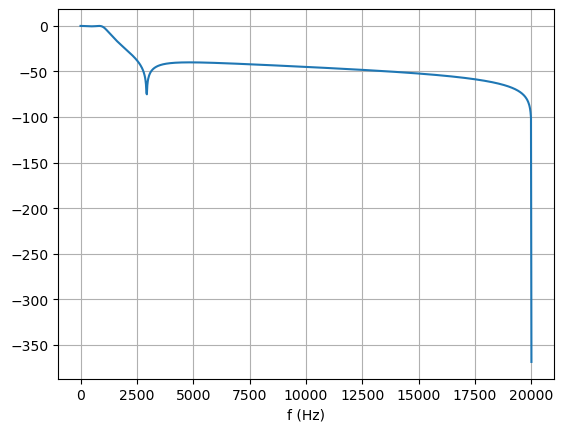

In [24]:
ω=range(0,π,length=1000)
H=freqz(zpkellip,ω);
plot(ω*fa/(2π), amp2db.(abs.(H)))
grid()
xlabel("f (Hz)");

Com o filtro projetado, precisamos verificar se ele realmente obedece às especificações.

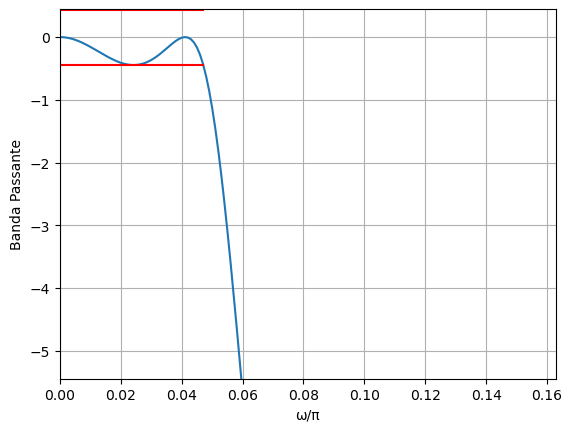

PyObject Text(24.000000000000007, 0.5, 'Banda Passante')

In [10]:
#Verificação dos requisitos
plot(ω./pi,amp2db.(abs.(H)))
plot([0;ωp/π],20*log10.([1-δp;1-δp]),color="red")
plot([0;ωp/π],20*log10.([1+δp;1+δp]),color="red")
axis([0,1.1*ωp,-Ap-5,Ap])
grid()
xlabel("ω/π")
ylabel("Banda Passante")

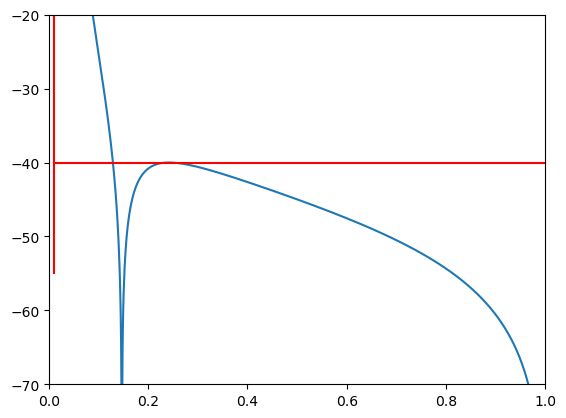

(0.0, 1.0, -70.0, -20.0)

In [18]:
#Verificação dos requisitos
plot(ω./pi,amp2db.(abs.(H)))
plot([ωr;π]/π,20*log10.([δr;δr]),color="red")
plot([ωr;ωr]/π,[-Ar-15;5],color="red")
axis([0, 1, -Ar-30, -Ar+20])

Agora podemos observar o sinal filtrado pelo filtro quantizado

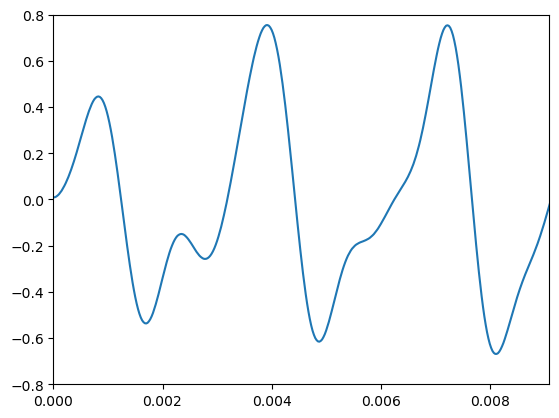

(0.0, 0.009094568176679734, -0.8, 0.8)

In [38]:
sqf = filt(b,a,sq)
plot(t, sqf)
axis([0,1/(35*pi),-0.8,0.8])

Subtraindo os sinais obtemos o erro de quantização na saída do filtro

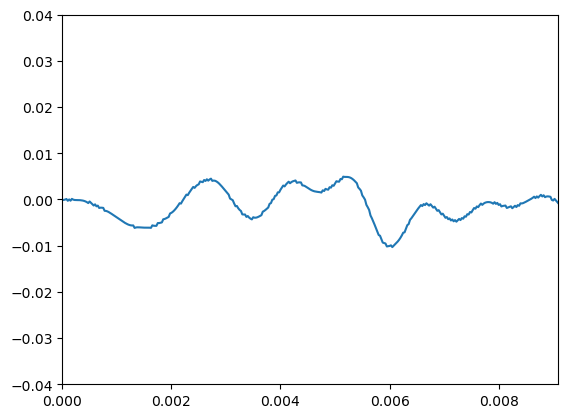

(0.0, 0.009094568176679734, -0.04, 0.04)

In [39]:
sf = filt(b,a,s)
plot(t, sqf-sf)
axis([0,1/(35*pi),-0.04,0.04])

Para achar a potência do ruído na saída, utilizamos a potência já achada ateriormente $ \sigma $ multiplicado pela soma dos coeficientes do filtro.

Dessa forma, podemos achar a Densidade Espectral de Potência na saída como: $ SNR_{saída} = \frac{Pot_{Sinal}}{Pot_{Ruído}} $ 

In [15]:
#Cálculo do SNR da saída
PotRuido = σ20*sum(impz(zpkellip,500).^2)
SNRsaida = pow2db(PotSinal/PotRuido)
print(SNRsaida, " dB")

40.84616813469922 dB

## Sinal Filtrado com precisão finita

Agora vamos utilizar a função "fxfilt" fornecida para quantizar os sinais usando precisão finita de 12 bits

In [64]:
#Ex5
include("fxfilt.jl")
B=12
Bc = 12
aq = Fixed{Int64,Bc-1}.(a)
bq = Fixed{Int64,Bc-1}.(b)

sqqf=fxfilt(bq,aq,Fixed{Int128,B-1}.(sq), true)

120001-element Array{Q116f11,1} with eltype Fixed{Int128, 11}:
  0.0093Q116f11
  0.0107Q116f11
  0.0161Q116f11
  0.0269Q116f11
  0.0444Q116f11
  0.0728Q116f11
  0.1138Q116f11
  0.1724Q116f11
  0.251Q116f11
  0.3535Q116f11
  0.4824Q116f11
  0.6392Q116f11
  0.8237Q116f11
  ⋮
 -3.706235497479736e31Q116f11
 -2.746179574576061e31Q116f11
 -3.982028731355213e31Q116f11
 -3.278294010261174e31Q116f11
  1.896783919517735e31Q116f11
 -3.6404666965303355e31Q116f11
 -5.036620772494466e30Q116f11
  1.9855042373700998e31Q116f11
  3.2839003798421494e31Q116f11
  2.138864531787052e31Q116f11
 -3.227749416031051e31Q116f11
  1.2977061678556155e31Q116f11

In [25]:
σ2=2.0^(-2*B)/3
PotRuido3 = σ20*sum(impz(hq,500).^2) + σ2*sum(impz(1,aq).^2);
#PotRuido_Pratico = var(sq_pf-sq_f)

LoadError: MethodError: no method matching impz(::Vector{Q51f12}, ::Vector{Q52f11})
[0mClosest candidates are:
[0m  impz([91m::FilterCoefficients{:z}[39m, ::Any) at C:\Users\jean_\AppData\Local\Programs\Julia-1.7.2\share\julia\base\deprecated.jl:70

## Calculos Teóricos para a precisão finita

considerando o filtro implementado em sua forma direta, podemos dizer que o sinal de um sistema com quantizações no filtro e no sinal pode ser representado pela soma de 3 parcelas:

$$  y_q[n] = y[n]+y_{e0}[n]+y_{e1}[n] $$

Sendo: 
$y[n]$ a resposta original,
$y_{e0}[n]$ o ruído de quantização do sinal e 
$y_{e1}[n]$ o erro das contas intermediárias

1. A parcela referente a resposta do sinal original sem quantização passando pelo filtro
quantizado. Nesse caso consideramos as contas com precisão infinita. Está saída terá
a forma:

$$ y[n] = s[n]*hq[n]  \\
Sy(e^{j\omega}) = S(e^{j\omega})Hq(e^{j\omega})$$ 

2. O erro da quantização do sinal passa por todo o filtro:
$$ y_{e0}[n] = e_0[n]*hq[n] $$

Onde $ e_0 $ é o erro de quantização visto nos outros exercícios e terá uma potência final de:

$$ P_{e0} = \sigma^2_{e0} \sum\limits_{n=-\infty}^{\infty} |h_q[n]|^2 $$

3. A saída do ruído das contas passa apenas pelos coeficientes do denominador ($g_q[n]$)

$$ y_{e1}[n]=e_1[n]*g_q[n] $$

Em que $ e_1 $é a soma dos erros de todas as contas, mas como estamos usando precisão dupla, há apenas o
erro de arredondamento final das contas. A variância deste erro vale $\sigma^2 = \frac{2^{-B}}{3}$


Para saber a potência do ruído de contas na saída, usamos as transformadas de Fourier:

$$ Se_1(e^{j \omega}) = \sigma^2 \\
Sy_{e1}(e^{j \omega}) = Se_1(e^{j \omega})|G(e^{j \omega})|^2 \\
P_{e1} = \frac{1}{2 \pi} \int_{- \pi}^{\pi}Sy_{e1}(e^{j \omega})=\frac{1}{2 \pi} \int_{- \pi}^{\pi}Sy_{e1}Se_1(e^{j \omega})|G(e^{j \omega})|^2 $$


E usando o teorema de Parseval temos:

$$ P_{e1} = \sigma^2 \sum g[n]^2 $$


## Calculos teóricos para o filtro canônico

Neste caso, os cálculos permanecem praticamente os mesmos. Entretando, o caminho percorrido pelo sinal é diferente, pois ó erro gerado pelas precisão finita vai passar por todos os coeficiêntes do filtro $hq[n]$, não só o denominador que nem no caso passado.

Portanto, o cálculo da potência $P_{e1}$ fica:

$$ P_{e1} = \sigma^2 \sum hq[n]^2 $$